# Model

Image: 64x32 or 128x32 depending on length?
conv+relu+pooling until 512 channels, height 1
two-layer bidirectional lstm

(n, channel, height, width)
- (n, 1, 32, 128)
- (n, 64, 32, 128), relu, pool (n, 64, 16, 64)
- (n, 128, 16, 64), relu, pool (n, 128, 8, 32)
- (n, 256, 8, 32), batchnorm, relu
- (n, 256, 8, 32), relu, pool (n, 256, 4, w), w = 16 or 32
- (n, 512, 4, w), batchnorm, relu
- (n, 512, 4, w), relu, pool (n, 512, 2, w)
- (n, 512, 2, w) -> (n, 512, 1, w) padding 0

stride 1, padding 1 except for last, kernel 3 except 2 in last

lstm takes (w, n, c=512)

Apply log_softmax to output before feeding to CTCLoss

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag

import dataset as ds

In [185]:
class TextRecognizer(nn.Module):
    def __init__(self, nh, ncl, nci=1, nc=64, nco=512, w=16):
        '''
        nh: dimension of hidden layer of lstm
        ncl: no of classes
        nci: no of channels of input data
        nc: no of channels of first conv layer
        nco: no of channels of last conv layer
        w: width of last conv layer (16 or 32)
        '''
        super(TextRecognizer, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # (64,32,128)
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (64,16,64)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128,16,64)
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (128,8,32)
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # (256,8,32)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (256,4,w) w=16
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # (512,4,w)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2), (2,1), (0,1)), # (256,2,w)
            nn.Conv2d(512, 512, kernel_size=2, padding=0) # (256,1,w)
        )
        
        self.lstm = nn.LSTM(512, nh, num_layers=2, bidirectional=True)
        
        self.embed = nn.Linear(2*nh, ncl) # bidirectional layers concatenated
    
    def forward(self, input):
        conv = self.cnn(input)
        n, c, h, w = conv.size()
        assert h == 1
        conv = conv.squeeze(2).permute(2,0,1)
        # conv = torch.einsum('nchw->wnc', conv)
        
        lstm, _ = self.lstm(conv)
        w, n, nh = lstm.size()
        
        embed = self.embed(lstm.view(-1, nh))
        _, ncl = embed.size()
        return embed.view(w, n, ncl).log_softmax(2)

In [11]:
rec = TextRecognizer(512, 32)

In [12]:
%%time
res = rec(ag.Variable(torch.ones(50,1,32,128)))

CPU times: user 2.08 s, sys: 304 ms, total: 2.39 s
Wall time: 1.78 s


In [13]:
res.size()

torch.Size([16, 50, 32])

In [41]:
cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # (64,32,128)
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (64,16,64)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (128,16,64)
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (128,8,32)
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # (256,8,32)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2)), # (256,4,w) w=16
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # (512,4,w)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2,2), (2,1), (0,1)), # (256,2,w)
            nn.Conv2d(512, 512, kernel_size=2, padding=0) # (256,1,w)
        )

In [42]:
%%time
conv = cnn.forward(ag.Variable(torch.zeros(50,1,32,128)))

CPU times: user 1.05 s, sys: 120 ms, total: 1.17 s
Wall time: 1.12 s


In [43]:
%%time
torch.einsum('nchw->wnc', conv).size()

CPU times: user 5.68 ms, sys: 4.45 ms, total: 10.1 ms
Wall time: 5.72 ms


torch.Size([16, 50, 512])

In [44]:
%%time
conv.squeeze(2).permute(2,0,1).size()

CPU times: user 336 µs, sys: 146 µs, total: 482 µs
Wall time: 327 µs


torch.Size([16, 50, 512])

In [45]:
carr = conv.detach().numpy()
carr.shape

(50, 512, 1, 16)

In [46]:
%%time
np.einsum('nchw->wnc', carr).shape

CPU times: user 1.67 ms, sys: 1.34 ms, total: 3.01 ms
Wall time: 1.47 ms


(16, 50, 512)

In [15]:
import dataset as ds

import matplotlib.pyplot as plt
import cv2

In [164]:
%%time
iam = ds.IAMDataset('words', '/Users/atadenizaydin/Documents/course material/cs491/SimpleHTR/data',
                   msb=True, tabulate=True, sort=True)

CPU times: user 34.3 s, sys: 1.59 s, total: 35.8 s
Wall time: 37.6 s


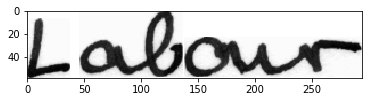

In [147]:
s = iam.samlist[10]
a = cv2.imread(s.path, cv2.IMREAD_GRAYSCALE)
plt.imshow(a, cmap='gray')

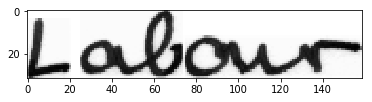

In [41]:
w = int(a.shape[1] / a.shape[0] * 32)
a = cv2.resize(a, (w, 32))
plt.imshow(a, cmap='gray')

In [162]:
s.text

'\n'

In [42]:
rec(ag.Variable(torch.Tensor(a.reshape(1,1,32,-1)))).size()

torch.Size([19, 1, 32])

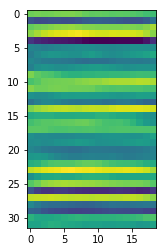

In [43]:
plt.imshow(rec(ag.Variable(torch.Tensor(a.reshape(1,1,32,-1)))).detach().numpy().reshape(-1, 32).T)

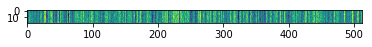

In [46]:
plt.imshow(rec.cnn(ag.Variable(torch.Tensor(a.reshape(1,1,32,-1)))).detach().numpy().reshape(512,-1).T)

In [54]:
np.array(list(map(ord, 'labour')), dtype='int32')-ord('a')

array([11,  0,  1, 14, 20, 17], dtype=int32)

In [67]:
torch.Tensor([int(w/8)])

tensor([19.])

In [61]:
print(torch.Tensor.__doc__)

None


In [130]:
rec = TextRecognizer(512, 27)

In [131]:
loss = nn.CTCLoss()
optimizer = optim.Adam(rec.parameters(), lr=1e-3)

In [132]:
input = ag.Variable(torch.Tensor(a.reshape(1,1,32,-1)))
targets = ag.Variable(torch.IntTensor(list(map(ord, 'labour')))-ord('a')+1)
in_lengths = ag.Variable(torch.IntTensor([int(w/8)]))
tar_lengths = ag.Variable(torch.IntTensor([targets.size()[0]]))

In [133]:
in_lengths

tensor([19], dtype=torch.int32)

In [134]:
%%time
eps = np.zeros(100)
for ep in range(eps.shape[0]):
    optimizer.zero_grad()
    output = rec(input)
    cost = loss(output, targets, in_lengths, tar_lengths)
    cost.backward()
    optimizer.step()
    eps[ep] = cost
    if ep % 10 == 0:
        print('Epoch %d: %f' % (ep, cost))

Epoch 0: 7.886497
Epoch 10: 1.580204
Epoch 20: 0.814723
Epoch 30: 0.418640
Epoch 40: 0.211289
Epoch 50: 0.118137
Epoch 60: 0.020908
Epoch 70: 0.007994
Epoch 80: 0.004302
Epoch 90: 0.002857
CPU times: user 3min 24s, sys: 40.8 s, total: 4min 4s
Wall time: 3min


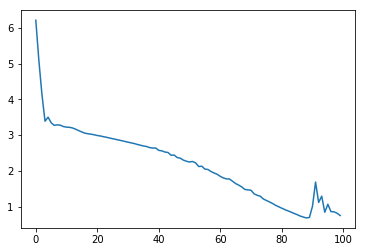

In [401]:
plt.plot(eps)
plt.show()

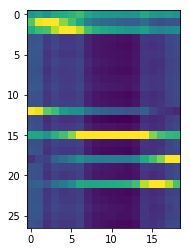

In [136]:
with torch.no_grad():
    output = rec(input)
plt.imshow(output.detach().numpy().reshape(-1, 27).T)

In [139]:
import preprocess as pr

In [431]:
from importlib import reload
reload(ds)
reload(pr)

<module 'preprocess' from '/Users/atadenizaydin/Documents/course material/cs491/nino-server/seg/preprocess.py'>

In [425]:
reload(pr)

<module 'preprocess' from '/Users/atadenizaydin/Documents/course material/cs491/nino-server/seg/preprocess.py'>

In [432]:
iamtr = pr.IAMTrainDataset(iam, 'train', 50, verbose=True, create=False)

Processing 81 batches of 4031 images of width 16 (1/31)
Processing 274 batches of 13672 images of width 32 (2/31)
Processing 321 batches of 16008 images of width 48 (3/31)
Processing 320 batches of 15996 images of width 64 (4/31)
Processing 270 batches of 13493 images of width 80 (5/31)
Processing 209 batches of 10438 images of width 96 (6/31)
Processing 147 batches of 7342 images of width 112 (7/31)
Processing 103 batches of 5146 images of width 128 (8/31)
Processing 71 batches of 3507 images of width 144 (9/31)
Processing 47 batches of 2334 images of width 160 (10/31)
Processing 31 batches of 1533 images of width 176 (11/31)
Processing 21 batches of 1037 images of width 192 (12/31)
Processing 14 batches of 678 images of width 208 (13/31)
Processing 9 batches of 443 images of width 224 (14/31)
Processing 6 batches of 281 images of width 240 (15/31)
Processing 4 batches of 155 images of width 256 (16/31)
Processing 3 batches of 124 images of width 272 (17/31)
Processing 2 batches of 79

In [357]:
samb = iamtr.samlist[1000]
samb

Sample('3-299')

In [358]:
bb = np.load(samb.path)

In [352]:
bb = bb[14:]
text = samb.text[samb.lengths[:14].sum():]
lengths = samb.lengths[14:]

In [359]:
n, h, w = bb.shape

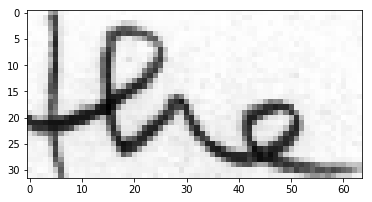

In [361]:
plt.imshow(bb[40], cmap='gray')
plt.show()

In [345]:
rec1 = TextRecognizer(512, 27)
loss1 = nn.CTCLoss(reduction='mean')
optimizer1 = optim.Adam(rec1.parameters(), lr=1e-3)

In [346]:
inputb1 = ag.Variable(torch.Tensor(bb.reshape(n,1,h,w)))
targets1 = ag.Variable(torch.IntTensor([ord(c)-ord('a')+1 if c.isalpha() else 1 for c in text.lower()]))
in_lengths1 = ag.Variable(torch.IntTensor([int(w/8)]*n))
tar_lengths1 = ag.Variable(torch.IntTensor(lengths))

In [347]:
in_lengths1.size()

torch.Size([36])

In [348]:
%%time
eps = np.zeros(100)
for ep in range(eps.shape[0]):
    optimizer1.zero_grad()
    output = rec1(inputb1)
    cost = loss1(output, targets1, in_lengths1, tar_lengths1)
    cost.backward()
    optimizer1.step()
    eps[ep] = cost
    if ep % 10 == 0:
        print('Epoch %d: %f' % (ep, cost))

Epoch 0: 6.629757
Epoch 10: 3.044316
Epoch 20: 2.744412
Epoch 30: 2.423383
Epoch 40: 2.049024
Epoch 50: 1.560494
Epoch 60: 1.069813
Epoch 70: 0.634588
Epoch 80: 0.381785
Epoch 90: 0.290798
CPU times: user 9min 28s, sys: 36.9 s, total: 10min 5s
Wall time: 7min 57s


In [258]:
output.shape

torch.Size([8, 36, 27])

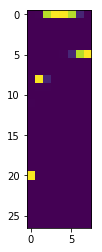

In [259]:
plt.imshow(np.exp(output.detach().numpy()[:,26,:]).T)
plt.show()

In [253]:
[ord(c)-ord('a')+1 if c.isalpha() else 1 for c in 'the']

[20, 8, 5]

In [239]:
np.exp(output.detach().numpy()[:,13,:]).sum(axis=1)

array([1.       , 1.0000001, 1.       , 1.       , 1.       , 0.9999998,
       1.       , 1.0000002], dtype=float32)

In [232]:
loss(output, targets, in_lengths, tar_lengths)

tensor([20.2929, 20.1739, 20.2327, 20.2608, 20.6830, 20.1432, 20.2195, 20.1699,
        21.8127, 20.0765, 20.2679, 23.6220,     inf, 20.2217, 20.2928, 20.0842,
        20.1449, 23.7362, 20.1557, 21.0426, 20.9375, 20.2135, 20.3132, 20.1517,
        26.4827, 23.7501, 20.9313, 21.0031, 20.1942, 20.1486, 20.1750, 26.2748,
        20.9295, 21.0041, 20.7316, 20.1463, 22.8970, 21.9548, 20.2871, 20.0846,
        20.1569, 23.7816, 20.6535, 20.1586, 20.1604, 20.1534, 20.0872, 20.1160,
        26.4469, 20.1703], grad_fn=<CtcLossBackward>)

In [216]:
targets

tensor([19,  1, 25,  2, 15,  4, 25,  8,  5, 18, 18,  5,  1, 12, 20, 21, 18, 14,
        19, 23,  5, 19, 20,  6, 15, 18,  2,  1,  3, 11, 13,  1, 11,  9, 14,  7,
        23,  9, 20,  8, 19, 21,  3,  8, 20,  1, 12,  5, 14, 20, 19,  6,  5,  5,
        12,  9, 14,  7, 19,  8,  9, 19,  4, 18, 15, 16, 23,  9, 20,  8, 20,  8,
         5, 12,  9, 20, 20, 12,  5, 20,  8,  5, 23,  5,  9, 14, 12,  1, 19, 20,
         1, 14,  4, 20,  8,  5, 16, 18,  5, 16,  1, 18,  5,  4, 15,  6,  6,  9,
         3,  5,  9, 14, 15,  6,  1, 14, 25, 20,  8,  5, 25,  5,  1, 18, 13,  5,
         5, 20,  9, 14,  7,  9, 14,  8,  5, 16,  9,  5,  3,  5, 14,  1, 20, 15,
         1, 16,  5, 15, 16, 12,  5, 16,  1, 21, 12, 20,  8,  1, 20, 20,  8,  5,
        12, 15,  7,  9,  3,  1, 12, 20,  8,  5,  9, 18, 20,  8,  5, 14, 15, 20,
        20,  8,  5, 20,  8,  9, 19, 11,  9, 14,  4,  3,  1, 16, 20, 21, 18,  5,
         4,  2,  1,  3, 11], dtype=torch.int32)

In [217]:
tar_lengths

tensor([3, 4, 3, 4, 5, 4, 3, 4, 6, 4, 4, 7, 8, 3, 4, 4, 3, 6, 3, 2, 2, 4, 3, 3,
        8, 6, 2, 2, 3, 3, 4, 7, 2, 2, 5, 4, 1, 6, 4, 4, 3, 7, 5, 3, 3, 3, 4, 4,
        8, 4], dtype=torch.int32)

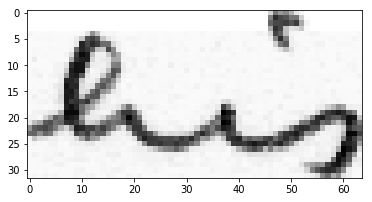

In [237]:
plt.imshow(bb[13], cmap='gray')
plt.show()

In [240]:
in_lengths[13]

tensor(8, dtype=torch.int32)

In [241]:
tar_lengths[13]

tensor(3, dtype=torch.int32)

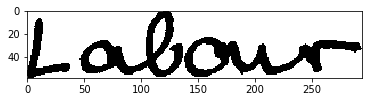

In [586]:
plt.imshow(a > s.thres, cmap='gray')
plt.show()

In [262]:
with torch.no_grad():
    testout = rec(input)

In [264]:
testout.shape

torch.Size([19, 1, 27])

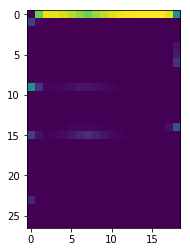

In [265]:
plt.imshow(np.exp(testout.detach().numpy().reshape(19,27)).T)
plt.show()

In [363]:
bb = np.load(samb.path)

In [364]:
bb = bb#[14:]
text = samb.text#[samb.lengths[:14].sum():]
lengths = samb.lengths#[14:]

In [365]:
n, h, w = bb.shape

In [366]:
%%time
with torch.no_grad():
    rec1 = TextRecognizer(512, 27)
    loss1 = nn.CTCLoss(reduction='none')
    inputb1 = ag.Variable(torch.Tensor(bb.reshape(n,1,h,w)))
    targets1 = ag.Variable(torch.IntTensor([ord(c)-ord('a')+1 if c.isalpha() else 1 for c in text.lower()]))
    in_lengths1 = ag.Variable(torch.IntTensor([int(w/8)]*n))
    tar_lengths1 = ag.Variable(torch.IntTensor(lengths))
    output = rec1(inputb1)
    cost = loss1(output, targets1, in_lengths1, tar_lengths1)

CPU times: user 1.27 s, sys: 211 ms, total: 1.48 s
Wall time: 1.35 s


In [367]:
cost

tensor([20.2996, 20.1733, 20.2738, 20.1231, 20.7463, 20.1526, 20.2625, 20.1475,
        21.8272, 20.0912, 20.2661, 23.6156,     inf, 20.2878, 20.1660, 20.0895,
        20.2505, 23.7054, 20.2332, 20.9799, 20.9746, 20.1439, 20.1810, 20.2415,
        26.3431, 23.7897, 20.9618, 21.0372, 20.2345, 20.2410, 20.1555, 26.3212,
        20.9801, 21.0744, 20.6706, 20.0875, 22.7349, 21.8614, 20.1381, 20.0961,
        20.2469, 23.5746, 20.6906, 20.2455, 20.1920, 20.2353, 20.1824, 20.1157,
        26.3127, 20.1480])

In [377]:
infs = [int(a[0]) for a in np.argwhere(np.isinf(cost))]
infs.sort(reverse=True) # needed in order to remove indices one by one
infs

[12]

In [385]:
# for each element in infs, remove it from batch, text and lengths
bb1 = bb
text1 = text
lengths1 = lengths
for ind in infs:
    bb1 = np.delete(bb1, ind, axis=0)
    text1 = text1[:lengths1[:ind].sum()] + text1[lengths1[:ind+1].sum():]
    lengths1 = np.delete(lengths1, ind)

In [386]:
bb1.shape

(49, 32, 64)

In [387]:
n1, h, w = bb1.shape

In [397]:
rec1 = TextRecognizer(512, 27)
loss1 = nn.CTCLoss(reduction='mean')
optimizer1 = optim.Adam(rec1.parameters(), lr=1e-3)

In [398]:
inputb1 = ag.Variable(torch.Tensor(bb1.reshape(n1,1,h,w)), requires_grad=True)
targets1 = ag.Variable(torch.IntTensor([ord(c)-ord('a')+1 if c.isalpha() else 1 for c in text1.lower()]))
in_lengths1 = ag.Variable(torch.IntTensor([int(w/8)]*n1))
tar_lengths1 = ag.Variable(torch.IntTensor(lengths1))

In [399]:
in_lengths1.size()

torch.Size([49])

In [400]:
%%time
eps = np.zeros(100)
for ep in range(eps.shape[0]):
    optimizer1.zero_grad()
    output = rec1(inputb1)
    cost = loss1(output, targets1, in_lengths1, tar_lengths1)
    cost.backward()
    optimizer1.step()
    eps[ep] = cost
    if ep % 10 == 0:
        print('Epoch %d: %f' % (ep, cost))

Epoch 0: 6.213845
Epoch 10: 3.223291
Epoch 20: 2.989296
Epoch 30: 2.802313
Epoch 40: 2.573885
Epoch 50: 2.248564
Epoch 60: 1.847091
Epoch 70: 1.458253
Epoch 80: 0.955757
Epoch 90: 1.008744
CPU times: user 12min 54s, sys: 33.3 s, total: 13min 27s
Wall time: 7min 12s


In [406]:
torch.isfinite(costs[15:])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)

In [407]:
import htr

In [563]:
from importlib import reload
reload(htr)

<module 'htr' from '/Users/atadenizaydin/Documents/course material/cs491/nino-server/seg/htr.py'>

In [568]:
trec = htr.TextRecognizer(lr=1e-3)

In [473]:
samb

Sample('3-299')

In [474]:
samb.checked = False

In [569]:
%%time
scores = trec.train(iamtr.samlist[600:700], verbose=10, eps=4)

Iteration 10: inf
Iteration 20: 0.068900
Iteration 30: 0.063984
Iteration 40: 0.069172
Iteration 50: 0.068100
Iteration 60: 0.064991
Iteration 70: 0.068584
Iteration 80: 0.065008
Iteration 90: 0.063888
Iteration 100: 0.063536
Iteration 110: inf
Iteration 120: 0.065414
Iteration 130: 0.061374
Iteration 140: 0.067169
Iteration 150: 0.063363
Iteration 160: 0.063128
Iteration 170: 0.066192
Iteration 180: 0.060817
Iteration 190: 0.061206
Iteration 200: 0.058030
Iteration 210: inf
Iteration 220: 0.055757
Iteration 230: 0.044813
Iteration 240: 0.054914
Iteration 250: 0.050112
Iteration 260: 0.050470
Iteration 270: 0.055201
Iteration 280: 0.045219
Iteration 290: 0.051333
Iteration 300: 0.049016
Iteration 310: inf
Iteration 320: 0.050428
Iteration 330: 0.039931
Iteration 340: 0.051451
Iteration 350: 0.046446
Iteration 360: 0.047530
Iteration 370: 0.050904
Iteration 380: 0.042875
Iteration 390: 0.049061
Iteration 400: 0.045706
CPU times: user 27min 6s, sys: 1min 10s, total: 28min 17s
Wall time: 

In [499]:
%%time
scores = trec.train(iamtr.samlist[200:600:2], verbose=20, eps=10)

Iteration 20: 1.285811
Iteration 40: 0.980917
Iteration 60: 1.629125
Iteration 80: 4.497238
Iteration 100: 2.893412
Iteration 120: 2.857885
Iteration 140: 2.099430
Iteration 160: 1.760744
Iteration 180: 1.743127
Iteration 200: inf
Iteration 220: 1.140361
Iteration 240: 0.905165
Iteration 260: 1.360353
Iteration 280: 4.565733
Iteration 300: 2.954562
Iteration 320: 2.849166
Iteration 340: 2.072846
Iteration 360: 1.696903
Iteration 380: 1.663427
Iteration 400: inf
Iteration 420: 1.132417
Iteration 440: 0.939968
Iteration 460: 1.402355
Iteration 480: 4.230413
Iteration 500: 2.834494
Iteration 520: 2.843206
Iteration 540: 1.990762
Iteration 560: 1.674861
Iteration 580: 1.551103
Iteration 600: inf
Iteration 620: 1.097524
Iteration 640: 0.812900
Iteration 660: 1.409550
Iteration 680: 4.152123
Iteration 700: 2.821033
Iteration 720: 2.816270
Iteration 740: 1.951191
Iteration 760: 1.632849
Iteration 780: 1.536930
Iteration 800: inf
Iteration 820: 1.121432
Iteration 840: 0.837873
Iteration 860: 1

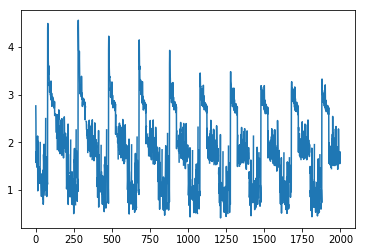

In [500]:
plt.plot(scores)
plt.show()

In [496]:
%%time
scores = trec.train(iamtr.samlist[600:700], verbose=10, eps=4)

Iteration 10: inf
Iteration 20: 3.288863
Iteration 30: 3.110970
Iteration 40: 3.326120
Iteration 50: 3.281174
Iteration 60: 3.142064
Iteration 70: 3.297750
Iteration 80: 3.127075
Iteration 90: 3.069144
Iteration 100: 3.067985
Iteration 110: inf
Iteration 120: 3.158773
Iteration 130: 2.992600
Iteration 140: 3.244528
Iteration 150: 3.083434
Iteration 160: 3.023106
Iteration 170: 3.180522
Iteration 180: 2.941768
Iteration 190: 2.959300
Iteration 200: 2.894417
Iteration 210: inf
Iteration 220: 2.730466
Iteration 230: 2.115776
Iteration 240: 2.655082
Iteration 250: 2.578538
Iteration 260: 2.433067
Iteration 270: 2.659899
Iteration 280: 2.169484
Iteration 290: 2.570700
Iteration 300: 2.366804
Iteration 310: inf
Iteration 320: 2.501689
Iteration 330: 1.970793
Iteration 340: 2.426146
Iteration 350: 2.287870
Iteration 360: 2.298030
Iteration 370: 2.420786
Iteration 380: 2.050580
Iteration 390: 2.363007
Iteration 400: 2.185000
CPU times: user 31min 27s, sys: 1min 1s, total: 32min 28s
Wall time: 

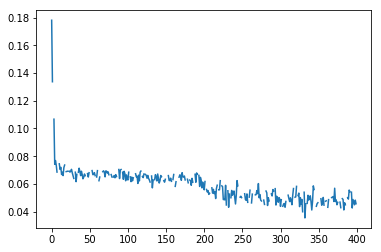

In [570]:
plt.plot(scores)
plt.show()

In [572]:
%%time
scores = trec.train(iamtr.samlist[800:1000], verbose=20, eps=4)

Iteration 20: 0.044530
Iteration 40: inf
Iteration 60: inf
Iteration 80: inf
Iteration 100: 0.038353
Iteration 120: 0.039362
Iteration 140: 0.039483
Iteration 160: 0.040977
Iteration 180: 0.037287
Iteration 200: 0.037270
Iteration 220: 0.039208
Iteration 240: inf
Iteration 260: inf
Iteration 280: inf
Iteration 300: 0.035252
Iteration 320: 0.037523
Iteration 340: 0.035620
Iteration 360: 0.037278
Iteration 380: 0.035874
Iteration 400: 0.033811
Iteration 420: 0.035379
Iteration 440: inf
Iteration 460: inf
Iteration 480: inf
Iteration 500: 0.033189
Iteration 520: 0.035737
Iteration 540: 0.032040
Iteration 560: 0.033502
Iteration 580: 0.032019
Iteration 600: 0.031604
Iteration 620: 0.031252
Iteration 640: inf
Iteration 660: inf
Iteration 680: inf
Iteration 700: 0.029742
Iteration 720: 0.031872
Iteration 740: 0.028088
Iteration 760: 0.031747
Iteration 780: 0.030957
Iteration 800: 0.027752
CPU times: user 1h 27min 15s, sys: 3min 16s, total: 1h 30min 32s
Wall time: 53min 35s


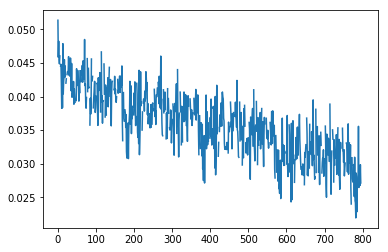

In [573]:
plt.plot(scores)
plt.show()

In [575]:
np.isinf(scores).sum()/len(scores)

0.14

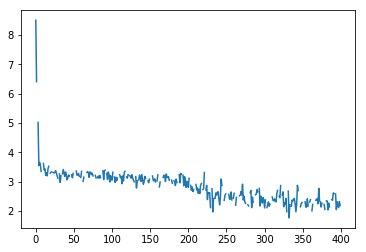

In [497]:
plt.plot(scores)
plt.show()

In [491]:
%%time
scores = trec.train(iamtr.samlist[500:520], verbose=10, eps=20)

Iteration 10: 2.781487
Iteration 20: 2.903193
Iteration 30: 2.789490
Iteration 40: 2.911816
Iteration 50: 2.808728
Iteration 60: 2.904442
Iteration 70: 2.807475
Iteration 80: 2.894804
Iteration 90: 2.818458
Iteration 100: 2.888176
Iteration 110: 2.810699
Iteration 120: 2.881685
Iteration 130: 2.802428
Iteration 140: 2.881972
Iteration 150: 2.795087
Iteration 160: 2.876505
Iteration 170: 2.799182
Iteration 180: 2.874360
Iteration 190: 2.794110
Iteration 200: 2.870930
Iteration 210: 2.791736
Iteration 220: 2.872919
Iteration 230: 2.788676
Iteration 240: 2.875626
Iteration 250: 2.799785
Iteration 260: 2.868978
Iteration 270: 2.799282
Iteration 280: 2.865036
Iteration 290: 2.796334
Iteration 300: 2.876235
Iteration 310: 2.792416
Iteration 320: 2.870354
Iteration 330: 2.802742
Iteration 340: 2.864365
Iteration 350: 2.807518
Iteration 360: 2.860716
Iteration 370: 2.803412
Iteration 380: 2.859736
Iteration 390: 2.804858
Iteration 400: 2.859247
CPU times: user 4h 31min 14s, sys: 2min 44s, tota

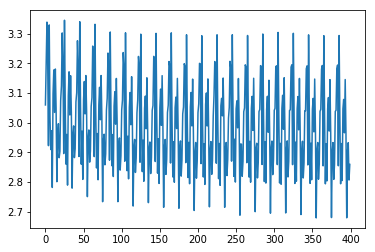

In [492]:
plt.plot(scores)
plt.show()

In [546]:
sambb = iamtr.samlist[955]

In [547]:
sambb.checked

True

In [576]:
bb2 = np.load(sambb.path)

In [577]:
bb3 = trec.check(sambb, bb2)

In [596]:
bb3 = np.array(a > s.thres, dtype='int32').reshape((1,)+a.shape)

In [600]:
ab = cv2.resize(a, (int(s.w / s.h * 32), 32))

In [602]:
ab = cv2.threshold(ab, s.thres, 255, cv2.THRESH_BINARY)[1]

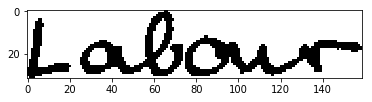

In [603]:
plt.imshow(ab, cmap='gray')
plt.show()

In [605]:
bb3 = ab.reshape((1,)+ab.shape)

In [1]:
n, h, w = bb3.shape
input3 = ag.Variable(torch.Tensor(bb3.reshape(n,1,h,w)))
targets3 = ag.Variable(torch.IntTensor(trec.encode(sambb.text)))
in_lengths3 = ag.Variable(torch.IntTensor([int(w/8)]*n))
tar_lengths3 = ag.Variable(torch.IntTensor(sambb.lengths))
with torch.no_grad():
    output3 = trec.rec(input3)
    cost3 = trec.loss1(output3, targets3, in_lengths3, tar_lengths3)

NameError: name 'bb3' is not defined

In [607]:
n, h, w = bb3.shape
with torch.no_grad():
    testout = trec.rec(ag.Variable(torch.Tensor(bb3.reshape(n,1,h,w))))

In [608]:
testout.shape

torch.Size([19, 1, 27])

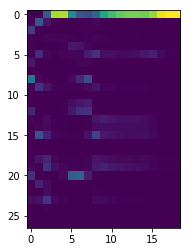

In [609]:
plt.imshow(np.exp(testout.detach().numpy()[:,0,:].reshape(-1,27)).T)
plt.show()

In [610]:
[ord(c)-ord('a')+1 for c in 'labour']

[12, 1, 2, 15, 21, 18]

In [459]:
cost3

tensor([15.5015, 17.2188, 15.2136, 15.5063, 16.7298, 16.7420, 16.7421, 15.4087,
        15.5237, 15.3781, 15.2274, 16.7492, 15.3998, 16.7360, 15.5317, 15.4599,
        15.4006, 15.2212, 15.2239, 15.5138, 17.5566, 15.3633, 15.5274, 15.4644,
        15.4450, 15.2252, 15.2142, 16.7501, 16.2931, 15.4064, 16.7281, 15.4031,
        15.2943, 15.3979, 15.2428, 16.7336, 15.5032, 15.2534, 16.3860, 15.2213,
        17.5599, 17.3949, 15.4568, 16.7562, 15.3953, 15.2208, 16.7316, 15.2524,
        15.4633, 16.7338])

In [460]:
iamtr.samlist[500].checked

False

In [613]:
%%time
iamtr100 = pr.IAMTrainDataset(iam, 'train100', 100, verbose=True, create=True)

Processing 41 batches of 4031 images of width 16 (1/31)
Processing 137 batches of 13672 images of width 32 (2/31)
Processing 161 batches of 16008 images of width 48 (3/31)
Processing 160 batches of 15996 images of width 64 (4/31)
Processing 135 batches of 13493 images of width 80 (5/31)
Processing 105 batches of 10438 images of width 96 (6/31)
Could not read a01-117-05-02
Processing 74 batches of 7342 images of width 112 (7/31)
Processing 52 batches of 5146 images of width 128 (8/31)
Processing 36 batches of 3507 images of width 144 (9/31)
Processing 24 batches of 2334 images of width 160 (10/31)
Could not read r06-022-03-05
Processing 16 batches of 1533 images of width 176 (11/31)
Processing 11 batches of 1037 images of width 192 (12/31)
Processing 7 batches of 678 images of width 208 (13/31)
Processing 5 batches of 443 images of width 224 (14/31)
Processing 3 batches of 281 images of width 240 (15/31)
Processing 2 batches of 155 images of width 256 (16/31)
Processing 2 batches of 124

In [615]:
len(iamtr)

1946

In [616]:
reload(htr)
trec100 = htr.TextRecognizer(lr=5e-2)

In [ ]:
%%time
scores100 = trec100.train(iamtr.samlist, verbose=25, eps=10)

Iteration 25: 1.641169
Iteration 50: 1.198272
Iteration 75: 0.711400
Iteration 100: 7.056611
Iteration 125: 6.354909
Iteration 150: 7.808508
Iteration 175: 3.848723
Iteration 200: 2.814494
Iteration 225: 4.271708
Iteration 250: 3.912751
Iteration 275: 2.036044
Iteration 300: 2.396045
Iteration 325: inf
Iteration 350: 2.860272
Iteration 375: 8.348084
Iteration 400: 6.689806
Iteration 425: 5.048733
Iteration 450: inf
Iteration 475: 3.839252
Iteration 500: 4.579248
Iteration 525: 4.559753
Iteration 550: inf
Iteration 575: 4.048498
Iteration 600: 4.171526
Iteration 625: 3.694631
Iteration 650: 3.270257
Iteration 675: 3.276175
Iteration 700: 3.047002
Iteration 725: 3.066682
Iteration 750: 3.849035
Iteration 775: 2.293608
Iteration 800: 4.451994
Iteration 825: 3.524466
Iteration 850: 3.701153
Iteration 875: 3.517019
Iteration 900: 3.054113
Iteration 925: 3.272386
Iteration 950: 3.479676
Iteration 975: 3.450566
Iteration 1000: 3.621202
Iteration 1000 threw exception
Iteration 1025: 3.741770
I

Iteration 8025: 6.284509
Iteration 8050: 5.163635
Iteration 8075: 4.986548
Iteration 8100: inf
Iteration 8125: 4.994673
Iteration 8150: 11.426610
Iteration 8175: 7.275527
Iteration 8200: 5.366938
Iteration 8225: 4.494779
Iteration 8250: 4.505617
Iteration 8275: 4.594082
Iteration 8300: 4.603674
Iteration 8325: 4.206555
Iteration 8350: 5.128603
Iteration 8375: 5.520174
Iteration 8400: 3.663802
Iteration 8425: 3.893930
Iteration 8450: 3.970634
Iteration 8475: 3.942636
Iteration 8500: 3.313613
Iteration 8525: 3.945137
Iteration 8550: 3.047978
Iteration 8575: inf
Iteration 8600: 4.003231
Iteration 8625: 4.106511
Iteration 8650: 3.901643
Iteration 8675: 3.739175
Iteration 8700: 3.649457
Iteration 8725: 3.302813
Iteration 8750: 3.624295
Iteration 8775: 3.980456
Iteration 8784 threw exception
Iteration 8800: 3.241394
Iteration 8825: 4.657711
Iteration 8850: 3.346734
Iteration 8875: 3.745249
Iteration 8900: 5.546969
Iteration 8925: 3.711868
Iteration 8950: 3.529115
Iteration 8975: 3.450255
Ite

In [ ]:
plt.plot(scores100)
plt.show()